# Data Preparation

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import cv2

In [97]:
data = pd.read_csv("HAM10000_metadata.csv")
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [98]:
data["dx"].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

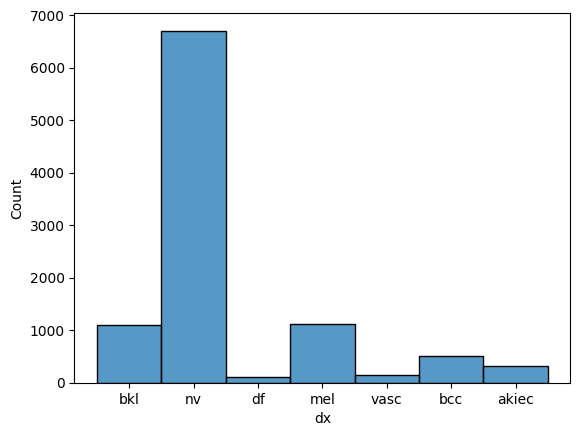

In [99]:
sns.histplot(data["dx"])
plt.show()

In [100]:
new_data = data.iloc[:,1:3]
new_data

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [25]:
# make dir to put data in
os.mkdir("data")

In [101]:
# make folder for each class
for i in range(len(data["dx"].unique())):
    dir_name = os.path.join("data", f"{data['dx'].unique()[i]}")
    os.mkdir(dir_name)

In [102]:
# put the images in their right places 

# first folder
for i in os.listdir("HAM10000_images_part_1"):
    image_id = i.split('.')[0]
    folder_name = new_data[new_data['image_id'] == image_id]['dx'].values[0]
    src = os.path.join("HAM10000_images_part_1", i)
    dest = os.path.join("data", folder_name, f'{folder_name}_{i}')
    shutil.copy(src, dest)
    

In [103]:
# second folder
for i in os.listdir("HAM10000_images_part_2"):
    image_id = i.split('.')[0]
    folder_name = new_data[new_data['image_id'] == image_id]['dx'].values[0]
    src = os.path.join("HAM10000_images_part_2", i)
    dest = os.path.join("data", folder_name, f'{folder_name}_{i}')
    shutil.copy(src, dest)
    

In [104]:
# the new data folder
for folder_name in os.listdir("data"):
    folder_path = os.path.join("data", folder_name)
    print(folder_name, "=", len(os.listdir(folder_path)))

akiec = 327
bcc = 514
bkl = 1099
df = 115
mel = 1113
nv = 6705
test = 7
train = 7
val = 7
vasc = 142


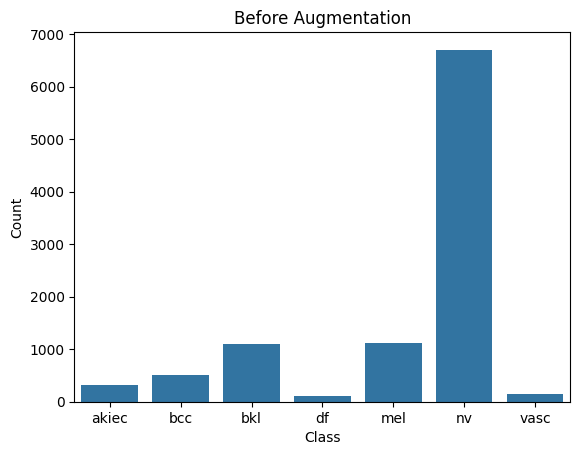

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    'Count': [327, 514, 1099, 115, 1113, 6705, 142]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('Before Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [118]:
# imbalanced dataset -> solve it with augmentation 

In [130]:
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, Resize, Compose
)

In [131]:
# Define the Albumentations augmentation pipeline
def get_augmentation_pipeline():
    return Compose([
        HorizontalFlip(p=1.0),
        VerticalFlip(p=1.0),
        RandomBrightnessContrast(p=1.0),
        Rotate(limit=45, p=1.0),
    ])

In [139]:
# Function to apply augmentations and balance the dataset
def balance_classes(classes, max_count, output_dir):
    augmentation_pipeline = get_augmentation_pipeline()
    
    for class_name, image_dir in classes.items():
        image_files = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
        num_images = len(image_files)
        num_to_generate = max_count - num_images
        
        # Directory to save augmented images
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        
        print(f"Augmenting class '{class_name}' to reach {max_count} images...")
        
        for i in range(num_to_generate):
            # Randomly pick an image for augmentation
            image_path = np.random.choice(image_files)
            image = cv2.imread(image_path)
            augmented = augmentation_pipeline(image=image)['image']
            
            # Save augmented image
            augmented_image_path = os.path.join(class_output_dir, f'aug_{i}.jpg')
            cv2.imwrite(augmented_image_path, augmented)
    
    print("Dataset balancing completed.")


In [140]:
classes = {
    "akiec": "data/akiec",
    "bcc": "data/bcc",
    "bkl": "data/bkl",
    "df": "data/df",
    "mel": "data/mel",
    "nv": "data/nv",
    "vasc": "data/vasc"
}

# Define the maximum number of images per class (target: 6705 for all classes)
max_count = 6705

# Output directory for the augmented dataset
output_dir = "data/augmented"

# Balance the dataset
balance_classes(classes, max_count, output_dir)

Augmenting class 'akiec' to reach 6705 images...
Augmenting class 'bcc' to reach 6705 images...
Augmenting class 'bkl' to reach 6705 images...
Augmenting class 'df' to reach 6705 images...
Augmenting class 'mel' to reach 6705 images...
Augmenting class 'nv' to reach 6705 images...
Augmenting class 'vasc' to reach 6705 images...
Dataset balancing completed.


In [141]:
# copy the augmented images into the original images

for folder_name in os.listdir("data/augmented"):
    folder_path = os.path.join("data", "augmented", folder_name)
    for image_name in os.listdir(folder_path):
        src = os.path.join(folder_path, image_name)
        dest = os.path.join("data", folder_name, image_name)
        shutil.copy(src, dest)


In [144]:
# the new data folder
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        folder_path = os.path.join("data", folder_name)
        print(folder_name, "=", len(os.listdir(folder_path)))

akiec = 6705
bcc = 6705
bkl = 6705
df = 6705
mel = 6705
nv = 6705
vasc = 6705


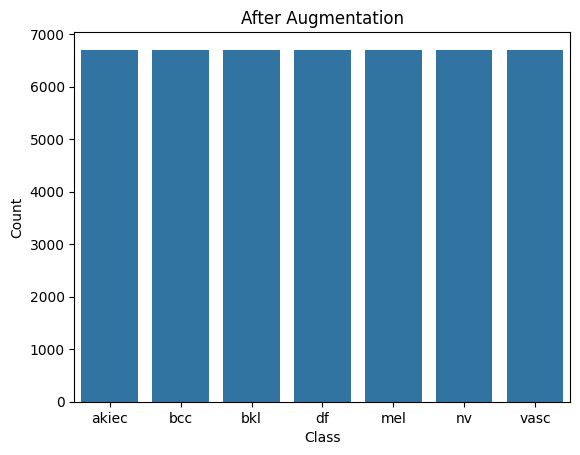

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    'Count': [6705, 6705, 6705, 6705, 6705, 6705, 6705]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('After Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [148]:
# train
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        folder_path = os.path.join("data", folder_name)
        print(folder_name, "=", round(len(os.listdir(folder_path))*0.7))

akiec = 4694
bcc = 4694
bkl = 4694
df = 4694
mel = 4694
nv = 4694
vasc = 4694


In [170]:
# train -> 4694
import random
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        working_images = random.sample(os.listdir(os.path.join("data", folder_name)), k=4694)
        for image_name in working_images:
            src = os.path.join("data", folder_name, image_name)
            dest = os.path.join("data", "train", folder_name, image_name)
            shutil.copy(src, dest)
            

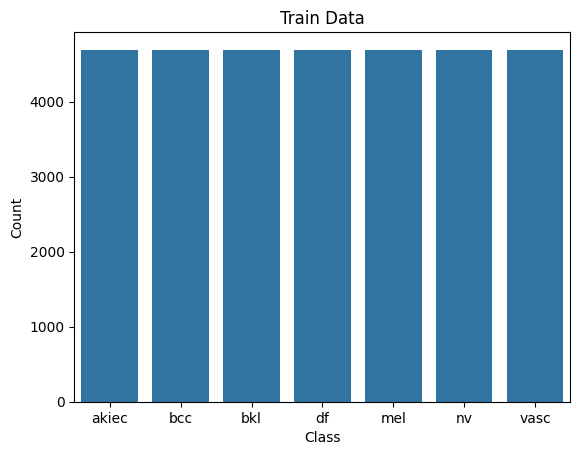

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    'Count': [4694, 4694, 4694, 4694, 4694, 4694, 4694]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [149]:
# test
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        folder_path = os.path.join("data", folder_name)
        print(folder_name, "=", round(len(os.listdir(folder_path))*0.2))

akiec = 1341
bcc = 1341
bkl = 1341
df = 1341
mel = 1341
nv = 1341
vasc = 1341


In [171]:
# test -> 1341
import random
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        working_images = random.sample(os.listdir(os.path.join("data", folder_name)), k=1341)
        for image_name in working_images:
            src = os.path.join("data", folder_name, image_name)
            dest = os.path.join("data", "test", folder_name, image_name)
            shutil.copy(src, dest)

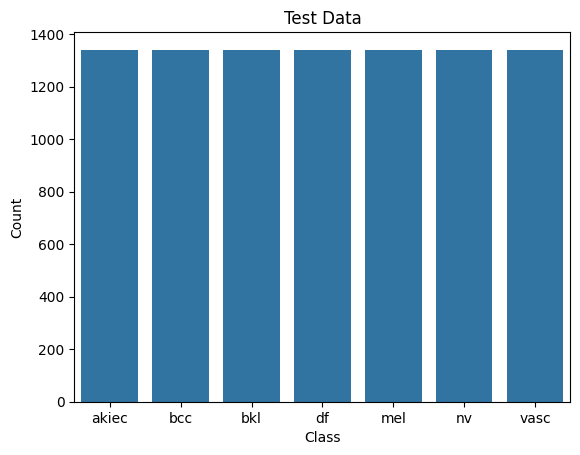

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    'Count': [1341, 1341, 1341, 1341, 1341, 1341, 1341]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [150]:
# val
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        folder_path = os.path.join("data", folder_name)
        print(folder_name, "=", round(len(os.listdir(folder_path))*0.1))

akiec = 670
bcc = 670
bkl = 670
df = 670
mel = 670
nv = 670
vasc = 670


In [172]:
# val -> 670
import random
for folder_name in os.listdir("data"):
    if folder_name not in ['train', 'test', 'val', 'augmented']:
        working_images = random.sample(os.listdir(os.path.join("data", folder_name)), k=670)
        for image_name in working_images:
            src = os.path.join("data", folder_name, image_name)
            dest = os.path.join("data", "val", folder_name, image_name)
            shutil.copy(src, dest)

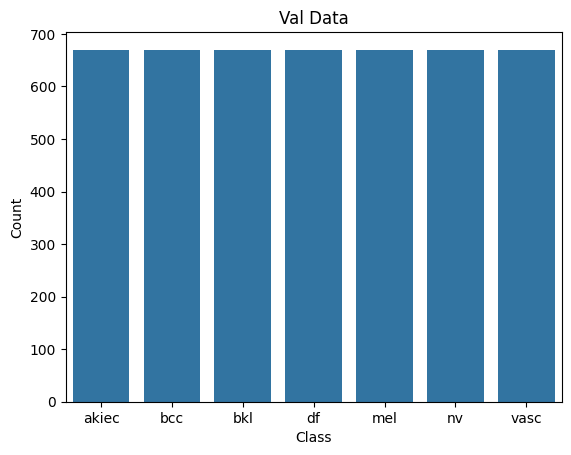

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    'Count': [670, 670, 670, 670, 670, 670, 670]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('Val Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [83]:
print("Train Data =", 4694*7)
print("Test Data =", 1341*7)
print("Val Data =", 670*7)
print("Total Number of Dataset =", 4694*7 + 1341*7 + 670*7)

Train Data = 32858
Test Data = 9387
Val Data = 4690
Total Number of Dataset = 46935


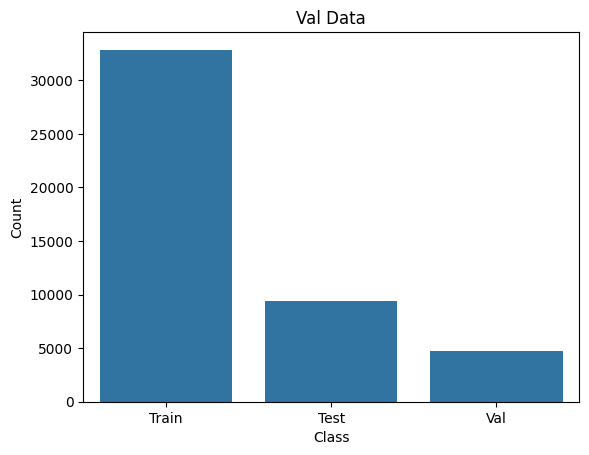

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
vis_data = {
    'Class': ['Train', 'Test', 'Val'],
    'Count': [4694*7, 1341*7, 670*7]
}

# Plot the histogram
sns.barplot(x=vis_data['Class'], y=vis_data['Count'])
plt.title('Val Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Model Building 

In [4]:
# libraries we will want 
from tensorflow.keras.applications import * 
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

# use gpu instead of cpu 
my_gpu = tf.config.experimental.list_physical_devices('GPU')[0]

# avoid oom error 
tf.config.experimental.set_memory_growth(my_gpu,True)

In [13]:
import os

train_dir = os.path.join("data/train") 

test_dir = os.path.join("data/test") 

val_dir = os.path.join("data/val") 

train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (224, 224), batch_size = 32)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (224, 224), batch_size = 32, shuffle=False)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size = (224, 224), batch_size = 32)


Found 32858 images belonging to 7 classes.
Found 9387 images belonging to 7 classes.
Found 4690 images belonging to 7 classes.


In [8]:
vgg_16 = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (224,224,3), 
)

In [9]:
vgg_16.trainable = False

model_vgg = tf.keras.models.Sequential([
    vgg_16,
    tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dense(7, activation = 'softmax')
])

In [10]:
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

In [11]:
model_vgg.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         589952    
                                                                 
 p_re_lu (PReLU)             (None, 7, 7, 128)         6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          73792     
                                                                 
 p_re_lu_1 (PReLU)           (None, 7, 7, 64)          3136      
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

# Model Training

### Stage 1

In [13]:
# train : 
logdir='logs'

# we do something like check point for us to return back to a specific location 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# train 
hist = model_vgg.fit(train_generator, epochs=10, validation_data = val_generator, callbacks=[tensorboard_callback])

Epoch 1/10
1027/1027 [==============================] - 154s 136ms/step - loss: 1.2346 - accuracy: 0.5249 - auc_1: 0.8680 - precision_1: 0.7237 - recall_1: 0.3274 - val_loss: 1.0428 - val_accuracy: 0.5977 - val_auc_1: 0.9079 - val_precision_1: 0.7812 - val_recall_1: 0.4194
Epoch 2/10
1027/1027 [==============================] - 135s 131ms/step - loss: 0.8351 - accuracy: 0.6804 - auc_1: 0.9414 - precision_1: 0.7862 - recall_1: 0.5720 - val_loss: 0.7306 - val_accuracy: 0.7262 - val_auc_1: 0.9556 - val_precision_1: 0.8323 - val_recall_1: 0.6192
Epoch 3/10
1027/1027 [==============================] - 135s 132ms/step - loss: 0.6668 - accuracy: 0.7477 - auc_1: 0.9622 - precision_1: 0.8217 - recall_1: 0.6745 - val_loss: 0.5820 - val_accuracy: 0.7883 - val_auc_1: 0.9717 - val_precision_1: 0.8647 - val_recall_1: 0.7070
Epoch 4/10
1027/1027 [==============================] - 145s 141ms/step - loss: 0.5644 - accuracy: 0.7863 - auc_1: 0.9725 - precision_1: 0.8404 - recall_1: 0.7330 - val_loss: 0.5

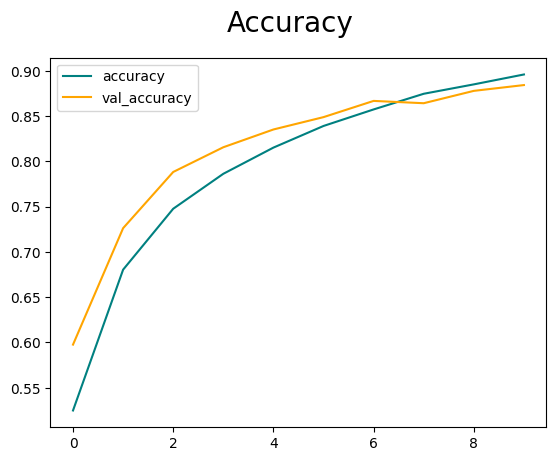

In [14]:
# plot for accuracy  
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [15]:
# model train on 10 epochs 
model_vgg.save(os.path.join("models","model_10epochs.h5"))

### Stage 2

In [16]:
hist_2 = model_vgg.fit(train_generator, validation_data = val_generator, epochs=20, initial_epoch=hist.epoch[-1], callbacks = [tensorboard_callback])

Epoch 10/20
1027/1027 [==============================] - 133s 129ms/step - loss: 0.2483 - accuracy: 0.9092 - auc_1: 0.9937 - precision_1: 0.9246 - recall_1: 0.8960 - val_loss: 0.3241 - val_accuracy: 0.9066 - val_auc_1: 0.9884 - val_precision_1: 0.9167 - val_recall_1: 0.8962
Epoch 11/20
1027/1027 [==============================] - 135s 131ms/step - loss: 0.2378 - accuracy: 0.9130 - auc_1: 0.9939 - precision_1: 0.9268 - recall_1: 0.9012 - val_loss: 0.3139 - val_accuracy: 0.9072 - val_auc_1: 0.9892 - val_precision_1: 0.9195 - val_recall_1: 0.8983
Epoch 12/20
1027/1027 [==============================] - 141s 137ms/step - loss: 0.2035 - accuracy: 0.9256 - auc_1: 0.9955 - precision_1: 0.9371 - recall_1: 0.9166 - val_loss: 0.3220 - val_accuracy: 0.9096 - val_auc_1: 0.9889 - val_precision_1: 0.9205 - val_recall_1: 0.9006
Epoch 13/20
1027/1027 [==============================] - 137s 133ms/step - loss: 0.2040 - accuracy: 0.9281 - auc_1: 0.9949 - precision_1: 0.9377 - recall_1: 0.9199 - val_loss:

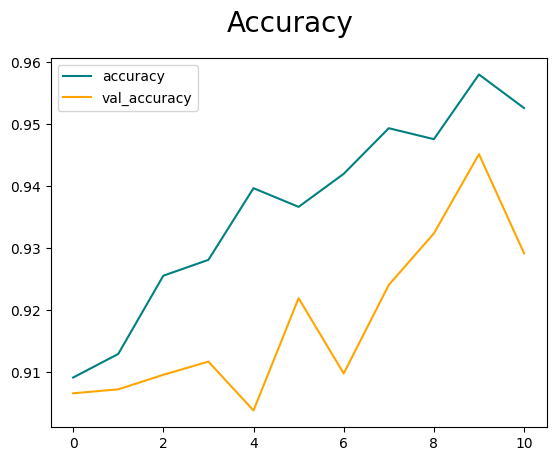

In [17]:
# plot for accuracy  
fig = plt.figure()
plt.plot(hist_2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [18]:
# model train on 20 epochs 
model_vgg.save(os.path.join("models","model_20epochs.h5"))

### Stage 3

In [19]:
hist_3 = model_vgg.fit(train_generator, validation_data = val_generator, epochs=30, initial_epoch=hist_2.epoch[-1], callbacks = [tensorboard_callback])

Epoch 20/30
1027/1027 [==============================] - 132s 128ms/step - loss: 0.1221 - accuracy: 0.9584 - auc_1: 0.9976 - precision_1: 0.9618 - recall_1: 0.9553 - val_loss: 0.2940 - val_accuracy: 0.9335 - val_auc_1: 0.9902 - val_precision_1: 0.9378 - val_recall_1: 0.9292
Epoch 21/30
1027/1027 [==============================] - 133s 130ms/step - loss: 0.1316 - accuracy: 0.9563 - auc_1: 0.9970 - precision_1: 0.9599 - recall_1: 0.9532 - val_loss: 0.4046 - val_accuracy: 0.9288 - val_auc_1: 0.9864 - val_precision_1: 0.9330 - val_recall_1: 0.9262
Epoch 22/30
1027/1027 [==============================] - 133s 130ms/step - loss: 0.1307 - accuracy: 0.9582 - auc_1: 0.9968 - precision_1: 0.9614 - recall_1: 0.9554 - val_loss: 0.3099 - val_accuracy: 0.9450 - val_auc_1: 0.9900 - val_precision_1: 0.9475 - val_recall_1: 0.9433
Epoch 23/30
1027/1027 [==============================] - 135s 131ms/step - loss: 0.1027 - accuracy: 0.9658 - auc_1: 0.9979 - precision_1: 0.9685 - recall_1: 0.9639 - val_loss:

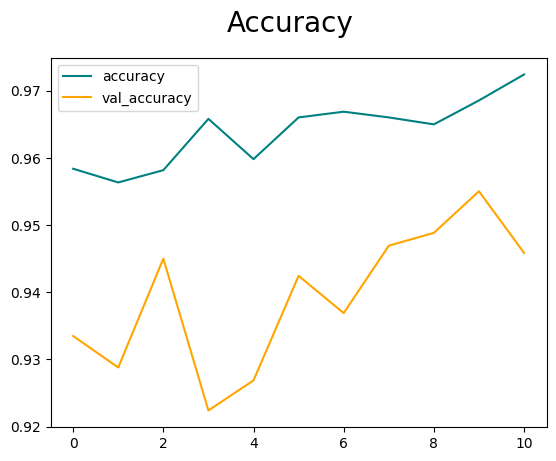

In [20]:
# plot for accuracy  
fig = plt.figure()
plt.plot(hist_3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
# model train on 30 epochs 
model_vgg.save(os.path.join("models","model_30epochs.h5"))

### Stage 4

In [22]:
hist_4 = model_vgg.fit(train_generator, validation_data = val_generator, epochs=40, initial_epoch=hist_3.epoch[-1], callbacks = [tensorboard_callback])

Epoch 30/40
1027/1027 [==============================] - 131s 128ms/step - loss: 0.0930 - accuracy: 0.9707 - auc_1: 0.9980 - precision_1: 0.9723 - recall_1: 0.9694 - val_loss: 0.4616 - val_accuracy: 0.9215 - val_auc_1: 0.9840 - val_precision_1: 0.9254 - val_recall_1: 0.9200
Epoch 31/40
1027/1027 [==============================] - 133s 129ms/step - loss: 0.0978 - accuracy: 0.9697 - auc_1: 0.9976 - precision_1: 0.9710 - recall_1: 0.9686 - val_loss: 0.4264 - val_accuracy: 0.9335 - val_auc_1: 0.9853 - val_precision_1: 0.9358 - val_recall_1: 0.9322
Epoch 32/40
1027/1027 [==============================] - 134s 131ms/step - loss: 0.0979 - accuracy: 0.9701 - auc_1: 0.9976 - precision_1: 0.9716 - recall_1: 0.9690 - val_loss: 0.3664 - val_accuracy: 0.9407 - val_auc_1: 0.9881 - val_precision_1: 0.9431 - val_recall_1: 0.9392
Epoch 33/40
1027/1027 [==============================] - 135s 132ms/step - loss: 0.1012 - accuracy: 0.9689 - auc_1: 0.9975 - precision_1: 0.9703 - recall_1: 0.9673 - val_loss:

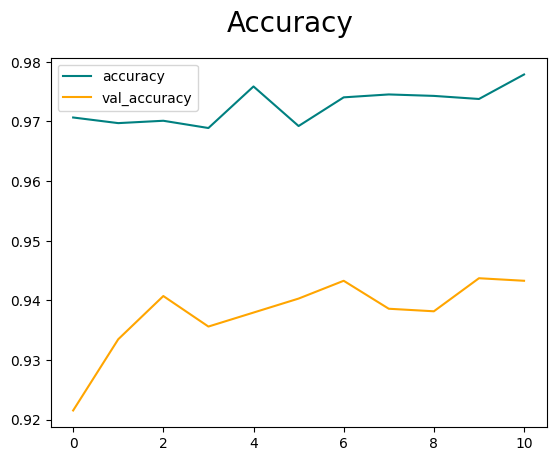

In [23]:
# plot for accuracy  
fig = plt.figure()
plt.plot(hist_4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
# model train on 40 epochs 
model_vgg.save(os.path.join("models","model_40epochs.h5"))

# Stage 5

In [25]:
hist_5 = model_vgg.fit(train_generator, validation_data = val_generator, epochs=50, initial_epoch=hist_4.epoch[-1], callbacks = [tensorboard_callback])

Epoch 40/50
1027/1027 [==============================] - 136s 132ms/step - loss: 0.0942 - accuracy: 0.9738 - auc_1: 0.9974 - precision_1: 0.9747 - recall_1: 0.9728 - val_loss: 0.4318 - val_accuracy: 0.9403 - val_auc_1: 0.9855 - val_precision_1: 0.9426 - val_recall_1: 0.9386
Epoch 41/50
1027/1027 [==============================] - 132s 129ms/step - loss: 0.0884 - accuracy: 0.9752 - auc_1: 0.9975 - precision_1: 0.9762 - recall_1: 0.9742 - val_loss: 0.3999 - val_accuracy: 0.9501 - val_auc_1: 0.9877 - val_precision_1: 0.9515 - val_recall_1: 0.9493
Epoch 42/50
1027/1027 [==============================] - 132s 129ms/step - loss: 0.0838 - accuracy: 0.9750 - auc_1: 0.9977 - precision_1: 0.9756 - recall_1: 0.9741 - val_loss: 0.3626 - val_accuracy: 0.9497 - val_auc_1: 0.9886 - val_precision_1: 0.9510 - val_recall_1: 0.9486
Epoch 43/50
1027/1027 [==============================] - 137s 133ms/step - loss: 0.0852 - accuracy: 0.9759 - auc_1: 0.9977 - precision_1: 0.9769 - recall_1: 0.9750 - val_loss:

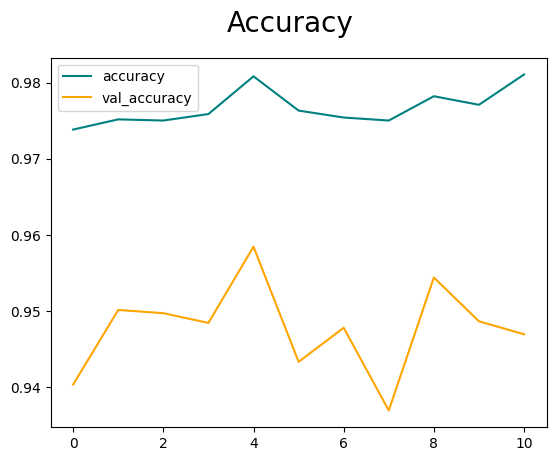

In [26]:
# plot for accuracy  
fig = plt.figure()
plt.plot(hist_5.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_5.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [27]:
# model train on 50 epochs 
model_vgg.save(os.path.join("models","model_50epochs.h5"))

# Evaluation

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import tensorflow as tf
import os
import cv2

In [36]:
# get the y_true and y_predict

# load the model
model_path = os.path.join("models", "model_50epochs.h5")
model = tf.keras.models.load_model(model_path)

result = model.predict(test_generator)

print(result)

294/294 [==============================] - 33s 112ms/step
[[1.0000000e+00 5.6399672e-36 2.0317494e-29 ... 0.0000000e+00
  3.0567564e-32 0.0000000e+00]
 [9.9999976e-01 9.6959567e-08 1.0802333e-07 ... 3.6354721e-11
  4.1655175e-17 5.7171870e-37]
 [1.6578997e-04 1.0711241e-17 1.7893914e-05 ... 9.9981636e-01
  2.4455504e-17 0.0000000e+00]
 ...
 [2.5668734e-09 1.9813193e-02 1.3403488e-04 ... 8.3297849e-01
  1.4707418e-01 7.4366831e-08]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.3787353e-38
  0.0000000e+00 1.0000000e+00]]


In [37]:
y_true = test_generator.classes
print(len(y_true))
print(y_true)

9387
[0 0 0 ... 6 6 6]


In [38]:
y_predict = np.argmax(np.rint(result), axis=1)
print(len(y_predict))
print(y_predict)

9387
[0 0 4 ... 4 6 6]


In [45]:
precision = precision_score(y_true, y_predict, average="micro")
print(precision)

0.9399169063598594


In [46]:
recall = recall_score(y_true, y_predict, average="micro")
print(recall)

0.9399169063598594


In [48]:
f_score = f1_score(y_true, y_predict, average="micro")
print(f_score)

0.9399169063598594


In [34]:
accuracy = accuracy_score(y_true, y_predict)
accuracy

0.9399169063598594

In [50]:
cm = confusion_matrix(y_true, y_predict)
cm

array([[1272,   18,   24,    1,   24,    2,    0],
       [  15, 1242,   28,    4,   40,   11,    1],
       [  22,   24, 1192,    5,   67,   31,    0],
       [   1,    2,    4, 1324,    5,    5,    0],
       [  13,   14,   50,    1, 1220,   42,    1],
       [   6,   10,   31,    2,   46, 1243,    3],
       [   1,    4,    0,    1,    5,    0, 1330]], dtype=int64)

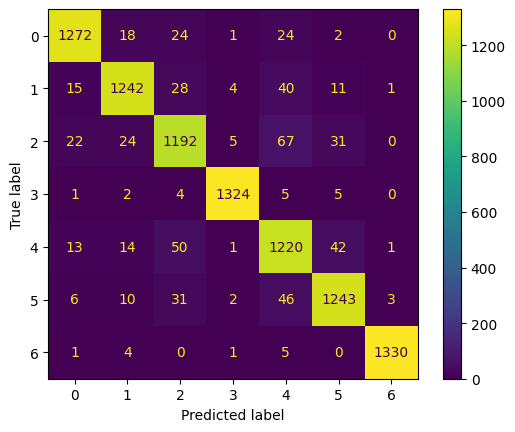

In [53]:
display_cm = ConfusionMatrixDisplay(cm)
display_cm.plot()

In [ ]:
# function to predict using image path 

class_mapping = {0:"Actinic Keratoses", 1:"Basal Cell Carcinoma", 2:"Benign Keratosis-like Lesions", 3:"Dermatofibroma", 4:"Melanoma", 5:"Melanocytic Nevi", 6:"Vascular Lesions"}


def predict(image_path):
    
    # read image from the path
    image = cv2.imread(image_path)
    
    # resize the image 
    resized_image = tf.image.resize(image, (224,224), method='nearest')
    
    # normalize the image and expand its dimension 
    model_input_image = np.expand_dims(resized_image/255, 0)
    
    # load the model
    model_path = os.path.join("models", "model_50epochs.h5")
    model = tf.keras.models.load_model(model_path)
    
    # predict with the model
    result = model.predict(model_input_image)
        
    # get the corressponding class_index
    return_result = dict()
    if max(result[0]) == result[0][0]:
        return_result['class'] = class_mapping[0]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    elif max(result[0]) == result[0][1]:
        return_result['class'] = class_mapping[1]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    elif max(result[0]) == result[0][2]:
        return_result['class'] = class_mapping[2]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    elif max(result[0]) == result[0][3]:
        return_result['class'] = class_mapping[3]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    elif max(result[0]) == result[0][4]:
        return_result['class'] = class_mapping[4]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    elif max(result[0]) == result[0][5]:
        return_result['class'] = class_mapping[5]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result
    
    else:
        return_result['class'] = class_mapping[6]
        return_result['confidence_ratio'] = round(max(result[0]), 2)
        return return_result

In [ ]:
image_path = os.path.join("data", "test", "vasc", "aug_1054.jpg")
result = predict(image_path)
print(result)

# Deployment

In [2]:
import os
import cv2
from uuid import uuid1
from flask import Flask, request, jsonify
from pyngrok import ngrok
import base64
from uuid import uuid1
import tensorflow as tf
import numpy as np

In [3]:
# function to predict using image path 

class_mapping = {0:"Actinic Keratoses", 1:"Basal Cell Carcinoma", 2:"Benign Keratosis-like Lesions", 3:"Dermatofibroma", 4:"Melanoma", 5:"Melanocytic Nevi", 6:"Vascular Lesions"}


def predict(image_path):
    
    # read image from the path
    image = cv2.imread(image_path)
    
    # resize the image 
    resized_image = tf.image.resize(image, (224,224), method='nearest')
    
    # normalize the image and expand its dimension 
    model_input_image = np.expand_dims(resized_image/255, 0)
    
    # load the model
    model_path = os.path.join("models", "model_50epochs.h5")
    model = tf.keras.models.load_model(model_path)
    
    # predict with the model
    result = model.predict(model_input_image)
        
    # get the corressponding class_index
    return_result = dict()
    if max(result[0]) == result[0][0]:
        return_result['class'] = class_mapping[0]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    elif max(result[0]) == result[0][1]:
        return_result['class'] = class_mapping[1]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    elif max(result[0]) == result[0][2]:
        return_result['class'] = class_mapping[2]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    elif max(result[0]) == result[0][3]:
        return_result['class'] = class_mapping[3]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    elif max(result[0]) == result[0][4]:
        return_result['class'] = class_mapping[4]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    elif max(result[0]) == result[0][5]:
        return_result['class'] = class_mapping[5]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result
    
    else:
        return_result['class'] = class_mapping[6]
        return_result['confidence_ratio'] = str(round(max(result[0]), 2))
        return return_result

In [4]:
app = Flask(__name__)
ngrok.set_auth_token("2dKjTfQjijoXk39hA3fjht8eIdA_3Fwq9DbjkDekQJTi6P1DJ")
public_url = ngrok.connect(5000).public_url

############# Convert Video To Video #####################
@app.route("/image_to_text", methods=['POST'])
def image_to_text():
    # get the image from the client
    image = request.files['image']
    image_filename = image.filename.split("/")[-1]

    # define a new unique file_name to save it in the folder
    random_value = uuid1()
    image_filename = f"uploaded_{random_value}_{image_filename}"
    image.save(os.path.join('uploaded_images', image_filename))
    image_path  = os.path.join('uploaded_images', image_filename)

    # apply model
    result = predict(image_path)
        
    return jsonify([result])


print(f"Full Path = {public_url}/image_to_text")
app.run(port=5000)

Full Path = https://a524-41-235-220-196.ngrok-free.app/image_to_text
 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


1/1 [==============================] - 9s 9s/step


127.0.0.1 - - [17/Nov/2024 18:25:25] "POST /image_to_text HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2024 18:25:35] "GET /image_to_text HTTP/1.1" 405 -


1/1 [==============================] - 0s 143ms/step


127.0.0.1 - - [17/Nov/2024 18:26:31] "POST /image_to_text HTTP/1.1" 200 -
